In [1]:
import pandas as pd
import numpy as np
import json
import requests
import urllib.request
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import requests
import seaborn as snb
import datetime
import networkx as nx

Birds of feather flock together: co-authorship network
-----
Duong Ton

# Motivation
Since I'm doing my PhD, the first priority of my professional is publishing. However, it is not an easy thing since there are multiple of factors to take into consideration when publishing, including but not limited to whom to write a paper with, which journals to submit. Therefore, I wanted to use this project to shed light on the culture of academia and subsequently and make smarter, data-based decisions on how to navigate academia. Orignially, I planned to conduct research on citation network of particular topics, as well as how determinants, including affiliation, country, h-index, number of citations relate to publishing outcome. However, due to time, financial and capability limit, I narrowed down to network of co-authorship in the field of economics.

# Introduction
This project consists of two parts: data gathering and data analysis. In data gathering process, which is highly time-consuming due to budget limit, I use both APIs and web-scraping to obtain author's data from Google Scholar, which include list of their co-authros, their h-index and number of citations they accumulate over years. There will be two sections in data analysis, one focuses on how likely authors with the similar h-index co-author with each other, the other address the questions whether authors with high citations and high h-index play more important role in the network. 

# Data Gathering
There are two separate sets of data needed for this project: network of co-author data and information about the authors data, including h-index and citations. The plan is to obtain network of co-author data, which would later be used to obtain information data. 

Due to API quota and the repition of multiple cells with the same format, I will open two saved json files after scraping data on the other python file (the messy file included in the zip file). Since the original notebook is more of experimenting, trying out different approach and testing how the data looks like and what I can do, it is messier and unorganized, not to mention extremely ineffcient. Initially I planned to stop at around 300-node network, but the network looks incomplete and inaccurate so I tried to get more codes, hence the incoherence and ineffciency of codes. When I finished data scrapping, I got a better sense on how to approach the problem in a more effecient way and how to write some functions as well as restructuring cells. However, due to quota limit, I cannot rewrite and rerun the whole process. 

This notebook is more of a lean version of how I would do if I do it all over again. In reality, this is the most time-consuming, manual, and exhausting part of the project. 

In [2]:
#Data of network of co-authors
with open("all_co.json","r") as f:
    all_co = json.load(f)

In [3]:
#Data of related inforamation on each author:
with open("information.json", 'r') as f:
    all = json.load(f)

In [6]:
all

{'John Van Reenen': ['EhUkIPEAAAAJ', 60714, 95],
 'Nick Bloom': ['fJy1tloAAAAJ', 58975, 76],
 'Raffaella Sadun': ['JvctKJcAAAAJ', 8620, 34],
 'Stephen Machin': ['GyGVDUIAAAAJ', 35108, 91],
 'Richard Blundell': ['ZCkKBLQAAAAJ', 91338, 96],
 'Gianmarco IP Ottaviano': ['-z6U4wQAAAAJ', 29343, 65],
 'Mirko Draca': ['h7N7aI8AAAAJ', 4063, 14],
 'Ralf Martin': ['INLQHkrsd2QJ', 17056, 59],
 'Swati Dhingra': ['yF4dmB4AAAAJ', 2475, 21],
 'Thomas Sampson': ['xtxnFFYAAAAJ', 3701, 19],
 'Lawrence Katz': ['MAqEdFMAAAAJ', 93271, 111],
 'Stephen Redding': ['HuH9c7kAAAAJ', 32740, 64],
 'Carol Propper': ['eK5s1U8AAAAJ', 17486, 68],
 'Brian David Bell': ['f7IwT2UAAAAJ', 3935, 27],
 'Xavier Jaravel': ['_PG9JHoAAAAJ', 2887, 16],
 'Luis Garicano': ['rjnKsr8AAAAJ', 9726, 39],
 'Lucia Foster': ['0UTBhgkAAAAJ', 8086, 20],
 'Itay Saporta Eksten': ['8c9wmXYAAAAJ', 3104, 10],
 'Ron Jarmin': ['0scD4MsAAAAJ', 11110, 40],
 'Raj Chetty': ['PhDDPiUAAAAJ', 37066, 56],
 'Christos Genakos': ['1wOcc74AAAAJ', 1864, 16],
 'E

### Network of co-author data
There are quite a few resources that provide API for academic data, regarding publications, journals, authors, among others. Here are a few outlets that I tried along with their pros and cons, and the reasons why I ended up (not) using them:
* Open Alex API: Open Alex is an open source, with no API key requirement. Open Alex offers decent . However, I could not find 
* Scopus API: Scopus offers with generous quota (20000 calls per account). However, when I used Scopus API to obtain author data, the supposed-to-be-json file is not json file and can't be read by response.json command. I've tried different command like urllib.request but it did not work either. Furthermore, in ordert to get author result, I had to input both author name and their affiliation
* Scholarly, got error. Even the sample code did not work when running on my laptop
* SerpAPI is a third party that provides API for Google Search, including Google Scholar. However, SerpAPI limits 20 calls/hour and 100 calls/month. I circumvent around the system by creating multiple accounts using temporary emails. 

I started with one author: David Autor since I have reading and he is one of the key author of my field of interest: automation and its implication on employment. Furthermore, he is also a prominent scholar who co-authors with various stars in the field. David Autor's network should include key scholars in the field. 
After getting data of Daivd Autor's network, which is around 30, I scrape data of their co-author network, with the average of around per 15 each author. In the end I get around 3434 nodes, equivalent to 3434 unique authors. 

To obtain data on co-authors, I first searched for author's Google ID and later use that ID for API call for co-author. The function is the combination of the two calls. 

In [ ]:
#Function to get the scholar's co-authors
def cox(a, apikey):
    name = a.replace(" ","+")
    url = 'https://serpapi.com/search.json?engine=google_scholar_profiles&mauthors='+name+'&hl=en&api_key='+apikey
    response = requests.get(url)
    result = response.json()
    author_id = result['profiles'][0]['author_id']

    url ='https://serpapi.com/search.json?engine=google_scholar_author&author_id='+author_id+'&view_op=list_colleagues&api_key='+apikey
    response = requests.get(url)
    result = response.json()
    ls = []
    try:
        for i in range(len(result['co_authors'])):
            ls.append(result['co_authors'][i]['name'])
    except KeyError:
        pass
    return ls

<details><summary><u>Process in codes</u></summary>
<p>

```python
apikey = ''
autor_co = {'David Autor': cox('David Autor', apikey)}
lsautor = list(autor_co.keys())
lay1 = {a: cox(a) for a in lsautor}

#create the first network, which 
G = nx.add_nodes_from(lay1)
ls = list(G.nodes())

#expand the network one more round
co2 = ls - lsautor #this list has about 300 values
lay2 = {a: cox(a, apikey) for a in co2}

#in the actual process, since I can only make 20 calls per hours for one Apikey, one cell would something like this
k1 = ''
k2 = ''
k3 = ''
k4 = ''
k5 = ''
lay21 = {a: cox(a, k1) for a in co2[:20]}
lay22 = {a: cox(a, k2) for a in co2[20:40]}
lay23 = {a: cox(a, k3} for a in co2[40:60]}
lay24 = {a: cox(a, k4) for a in co2[60:80]}
lay25 = {a: cox(a, k5) for a in co2[80:100]}

#the end result will be stored in the main dictionary
all_co = {}
all_co.update(lay21)

#The process repeats until I reach the end of the list. In the end, the network grows to around 3400 nodes
GG = nx.add_nodes_from(all_co)
li = list(GG.nodes())
```
    
</p>
</details>

### Relevant information about the authors

Since SerpAPI does not provide with scholars' cummulative citations and h-index, I decided to scrape Google webpage for each author for such information. Google author ID is in google URL. I can access each author's google scholar webpage after obtaining their ID with the API call. 

In [ ]:
def info(a, apikey):
    name = a.replace(" ","+")
    url = 'https://serpapi.com/search.json?engine=google_scholar_profiles&mauthors='+name+'&hl=en&api_key='+apikey
    response = requests.get(url)
    result = response.json()
    author_id = result['profiles'][0]['author_id']

    url = 'https://scholar.google.com/citations?user='+author_id+'&hl=en'
    req = urllib.request.Request(url, headers = {'User-agent':'Modzilla/5.0'})
    webpage = urllib.request.urlopen(req)
    soup = BeautifulSoup(webpage, "lxml")
    h = []
    for a in soup.find_all("td"):
        h.append(a.string)
    citation = int(h[1])
    hindex = int(h[4])
    return author_id, citation, hindex

<details><summary><u>Process in codes</u></summary>
<p>

```python
#Similar to how I obtained co-author data, I can only run 20 calls per one API call for each time
k1 = '1dac1ce23662d778401542f3ea5822e773046dac9a4a588b389220475cd5ae54'
k2 = '3c3df48cf1a8e12f7d5c99f8ba4455d6a825a40a1d952930c2838d9d5aaaf0bb'
k3 = 'ac86922287833f14daa3533a3cebbb1ce71f30fb95f6b2ceda3b628e94c9d99a'
k4 = '2bf4411edc401b94246d7c1e6cf2a5ad29563d93e4a1fab850533fd43eda3da9'
k5 = 'd2312b393d3345ccca423039a41e25bb8bb3dff5e6ec1e661b83437b76ee10f9'
info46 = {a: info(a,k1) for a in li[800:820]}
info47 = {a: info(a,k2) f or a in li[820:840]}
info48 = {a: info(a,k3) for a in li[840:860]}
info49 = {a: info(a,k4) for a in li[860:880]}
info50 = {a: info(a,k5) for a in li[880:900]}

#the process will be repeated about 35 times

```
</p>
</details>

After downloading all the neccessary data, I saved two dictionaries as two json files for further usage with the command. 

<p>

```python
json.dump(all, open("information.json","w"))
json.dump(all_co, open("all_co.json","w")

```
</p>

# Network Analysis
There are two approaches to the network analysis based on two hypotheses. First, I hypothesize that authors with high h-index or high citations would be more popular and important in the network, based on criteria like page-rank, centrality and betweeness. The first analysis would be finding the correlation-coeffecient between h-index/citations with other network indicies like page-rank or betweeness. Second, I hypothesize that authors with the same h-index or citations would tend to co-write a paper together. To test that hypothesis, there is a built-in function of networkx called ``` nx.numeric_assortativity_coefficient ```. To determine whether that is statistically significant, I would bootstrap the network with ``` nx.random_reference ```. However, since there are more than 3000 nodes in the network, each bootstrap takes 5 minutes. 100 boostraps would take about 8 hours. I would write the codes for the boostrap of 10 times, but might not be able to go through the process 100 times. 

## Preparing network data and preliminary analysis

In [4]:
el = []
for node,neighbors in all_co.items():
    for neighbor in neighbors:
        el.append((node,neighbor))
GG = nx.Graph()
GG.add_edges_from(el)

In [9]:
#remove nodes due to insufficient information (around 40 nodes don't have relevant information)
removelist = set(list(GG.nodes())) -set(list(all.keys()))
GG.remove_nodes_from(removelist)
len(list(GG.nodes()))

3434

In [111]:
#constructing dataframe
df_in = pd.DataFrame.from_dict(all, orient='index')
df_in.columns = ['ID','citations','h-index']

#constructing h-index and citations attributesof researchers of the network
nx.set_node_attributes(GG, values= df_in['citations'], name='citations')
nx.set_node_attributes(GG, values= df_in['h-index'], name = 'h-index')

In [121]:
df_in['h-index'].nlargest(n=10)

Ronald C Kessler      318
Robert Smith          294
Bert Vogelstein       278
Christopher Murray    237
Joseph E. Stiglitz    230
Lei Li                230
Cyrus Cooper          227
Gordon Mills          205
Robin M Murray        200
Zulfiqar Bhutta       191
Name: h-index, dtype: int64

Out of curiosity, I googled the scholars on the list. It is notable that most researchers the highest h-index in the network are not economists, but rather neuroscientists, physicians, and natural scientists. I have two explanations for this. The first, which is not exciting, is that there is an error in data-scraping. It could be due to shared names among researchers. The second possibility is that there might be co-authorship between behavioural economists and cognitive scientists/sociologists, which is highly probable since two disciplines are highly intertwined. Cognitive scientists also would tend to co-author paper with neuroscientists. Furthermore, economists also cover health-care policy, hence the need to co-author with researchers with medicine background. The interdisciplinary nature of academia might be the reason how the network expand to people from various academic background. 


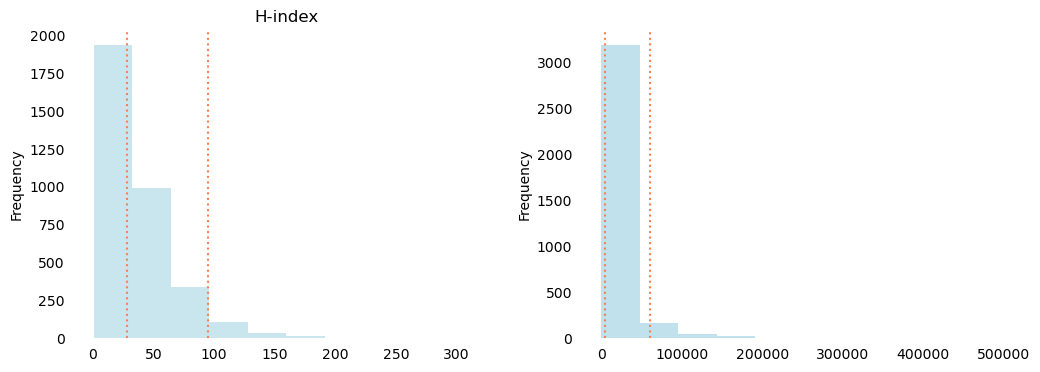

In [190]:
#plotting histogram for h-index of the authors in the network
plt.subplots(nrows=1, ncols=2, figsize=(12,4))

ax = plt.subplot(121)

#snb.histplot(df_in['h-index'])
df_in['h-index'].plot(kind = 'hist',  alpha = 0.65, color = 'lightblue')

ax.set_title("H-index")
quant50, quant_95 = df_in['h-index'].quantile(.5), df_in['h-index'].quantile(0.95)
ls = [quant50, quant_95]
for i in ls:
    plt.axvline(i, linestyle = ":",color = 'coral')
# Hide the right and top spines
plt.tick_params(left = False, bottom = False)
for ax, spine in ax.spines.items():
    spine.set_visible(False)


ax = plt.subplot(122)
df_in['citations'].plot(kind = 'hist', alpha = 0.75, color = 'lightblue')
quant50, quant_95 = df_in['citations'].quantile(.5), df_in['citations'].quantile(0.95)
ls = [quant50, quant_95]
for i in ls:
    plt.axvline(i, linestyle = ':', color = 'coral')
plt.tick_params(left = False, bottom = False)

for ax, spine in ax.spines.items():
    spine.set_visible(False)
plt.show()


Since there are outliers that distort the distribution, plot other histograms that zoom in the 90% of the distribution. 

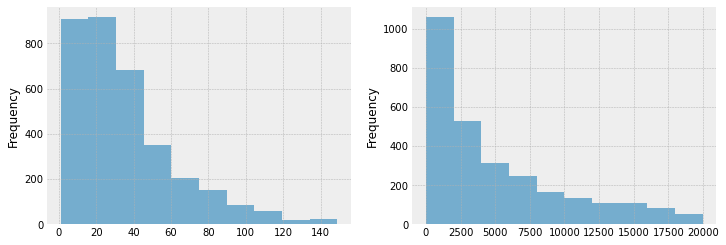

In [142]:
#plotting histogram for h-index of the authors in the network
plt.subplots(nrows=1, ncols=2, figsize=(12,4))

# Later in the code

ax = plt.subplot(121)
df_in['h-index'][df_in['h-index']<150].plot(kind = 'hist',alpha = 0.65)

# Hide the right and top spines
ax.tick_params(left = False, bottom = False)
for ax, spine in ax.spines.items():
    spine.set_visible(False)

ax = plt.subplot(122)
df_in['citations'][df_in['citations']<20000].plot(kind = 'hist',alpha = 0.65)

ax.tick_params(left = False, bottom = False)
for ax, spine in ax.spines.items():
    spine.set_visible(False)
plt.show()

## Plotting the Network

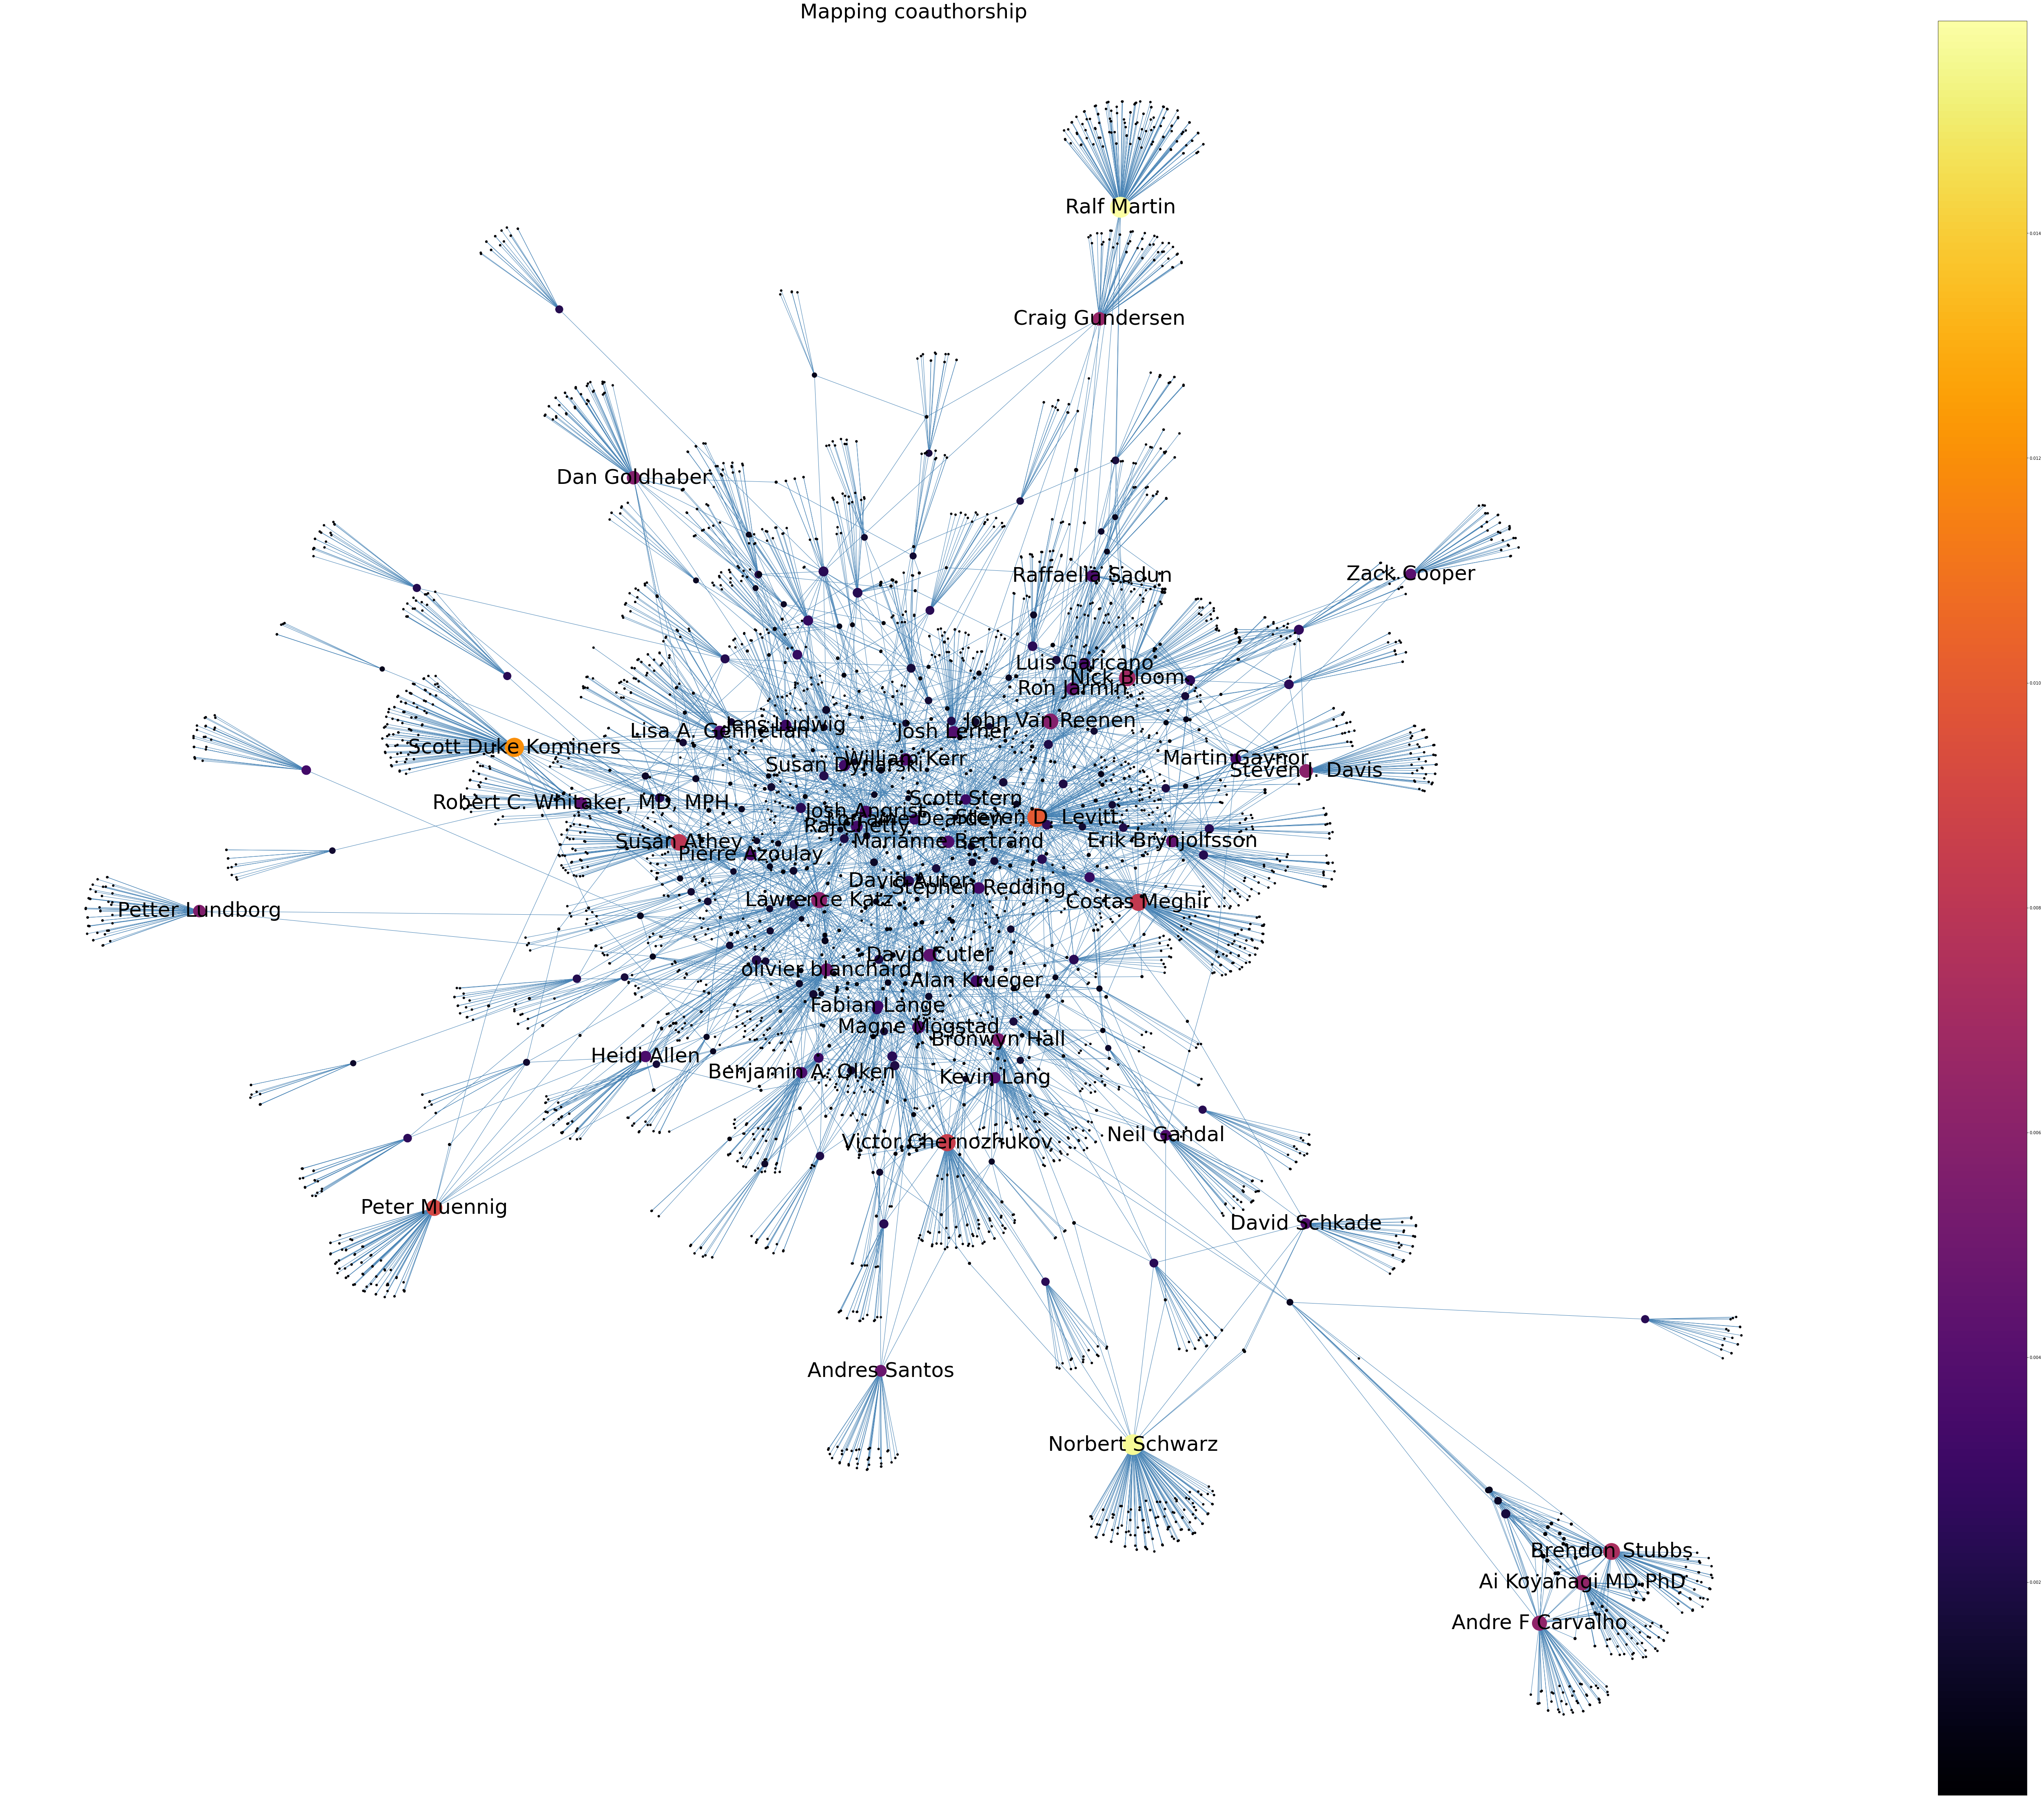

In [122]:
pos = nx.spring_layout(GG)

plt.figure(figsize=(100,80))

sizes = [ 20*GG.degree[node]+5 for node in GG.nodes]
dolphin_pr = nx.pagerank(GG)
colors = [ dolphin_pr[node] for node in GG.nodes]

pos = nx.spring_layout(GG)
s = nx.draw_networkx_nodes(GG, pos, node_size=sizes, node_color= colors,cmap='inferno')
cbar = plt.colorbar(s)
nx.draw_networkx_edges(GG, pos, edge_color='#4682B4')

#label top ten of centrality
centrality = dict(GG.degree())
degtop = sorted(centrality.keys(), key= lambda x:-centrality[x])[:50]
new_labels = {node:node for node in degtop}
nx.draw_networkx_labels(GG, pos, labels=new_labels, font_size=50)


plt.title('Mapping coauthorship', size = 50);
plt.axis('off');

## First Analysis 
Correlation between h-index, citations with pagerank, centrality and betweeness


In [118]:
#Node centrality 
central = pd.DataFrame.from_dict(centrality,orient='index')
central.columns = ['centrality']
print(central['centrality'].nlargest(n=10))
print('correlation coefficient between h-index and betweenness is',df_in['h-index'].corr(central['centrality']))
print('correlation coefficient between h-index and betweenness is',df_in['citations'].corr(central['centrality']))

Ralf Martin            126
Norbert Schwarz        124
Scott Duke Kominers    106
Steven D. Levitt       103
Costas Meghir           84
Victor Chernozhukov     84
Brendon Stubbs          81
Nick Bloom              79
Susan Athey             78
Peter Muennig           74
Name: centrality, dtype: int64
correlation coefficient between h-index and betweenness is 0.12297465211574972
correlation coefficient between h-index and betweenness is 0.08706028039214447


In [119]:
#create Dataframe for pagerank
pagerank = pd.DataFrame.from_dict(dolphin_pr, orient='index')
pagerank.columns = ['pagerank']
print(pagerank['pagerank'].nlargest(n=10))
print('correlation coefficient between h-index and page rank is',df_in['h-index'].corr(pagerank['pagerank']))
print('correlation coefficient between h-index and page rank is',df_in['citations'].corr(pagerank['pagerank']))

Ralf Martin            0.015888
Norbert Schwarz        0.015613
Scott Duke Kominers    0.011963
Steven D. Levitt       0.009953
Peter Muennig          0.009058
Victor Chernozhukov    0.008540
Costas Meghir          0.008292
Susan Athey            0.008057
Brendon Stubbs         0.007268
Nick Bloom             0.006871
Name: pagerank, dtype: float64
correlation coefficient between h-index and page rank is 0.11523117534213391
correlation coefficient between h-index and page rank is 0.07858618966929184


In [120]:
#Betweenness
between = nx.betweenness_centrality(GG)
betweenness = pd.DataFrame.from_dict(between, orient='index')
betweenness.columns = ['betweenness']
print(betweenness['betweenness'].nlargest(n=10))
print('correlation coefficient between h-index and betweenness is',df_in['h-index'].corr(betweenness['betweenness']))
print('correlation coefficient between h-index and betweenness is',df_in['citations'].corr(betweenness['betweenness']))


John Van Reenen     0.244498
David Autor         0.219331
Lawrence Katz       0.214630
Alan Krueger        0.130855
Pian Shu            0.103583
William Kerr        0.093772
Steven D. Levitt    0.085898
Josh Angrist        0.084368
Gordon Hanson       0.073632
Magne Mogstad       0.071486
Name: betweenness, dtype: float64
correlation coefficient between h-index and betweenness is 0.1144235369625861
correlation coefficient between h-index and betweenness is 0.10083488844166784


The correlation-coeffecients vary within the bound of [0:12,0:08], suggesting low correlation between h-index (citations) and network centrality indicies. My hypothesis is that since there are economists co-author with researchers from different fields, like health policy, epidemiology, neuroscience, for the shared topics or methodology. Researchers from said disciplines have significant higher citations and h-index, which skewed the distribution and the end results. 

## Second Analysis
For the second analysis, I will calculate the assortativity coeffecient, which means that how likely two nodes with similar attribute connect with each other. Afterwards, I will boostrap the network to see if the correlation coefficient is statistically significant. However, due to executing time, I will run a small demonstration how I would conduct the analysis. 

In [162]:
c = nx.numeric_assortativity_coefficient(GG, attribute='h-index')
c

0.14512445071512683

In [ ]:
#boostrap the process
values = []
for i in range(10):
    R = nx.random_reference(GG)
    co = nx.numeric_assortativity_coefficient(R, attribute='h-index')
    values.append(co)

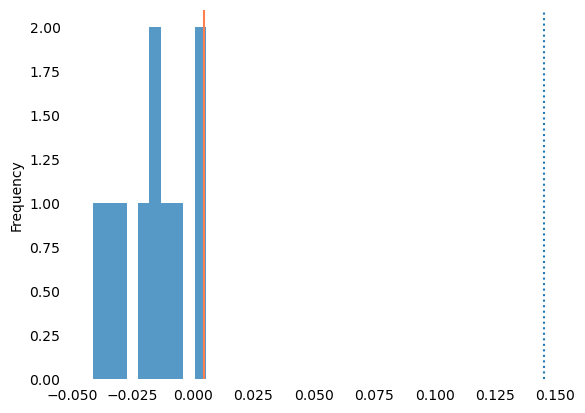

In [191]:
v = pd.Series(values)
fig, ax = plt.subplots()
v.plot(kind = 'hist',  alpha = 0.75)

ax.tick_params(left = False, bottom = False)
for ax, spine in ax.spines.items():
    spine.set_visible(False)

quant_95 =  v.quantile(0.95)

#plotting the 95 percentile line
plt.axvline(quant_95, color = 'coral')

#plotting the result
plt.axvline(c, linestyle = ":")

plt.show();

If the original assortativity coefficient is larger than the 95 percentile, it means it's significant. 
However, it only makes sense when the number of bootstrap is large enough (>1000)

# Conclusion
The most interesting finding is that when expanding the network of co-authorship by two folds, there are other researchers from different, even seemingly unrelated disciplines appearing in the network. I started out focusing on labour economics, I did not expect that it would expand to neuroscience and epidemiology through behavioral econonomics and health policy, that's why I didn't include that information when scraping the data. This shows that researchers do not confine themselves in one particular specialization. Many researchers also co-author due to shared methodology, especially randomized control trials (RCT). RCT's popularity has been growing in the field economics and becoming the gold standard for causal reference. As many economists adopt the method, they expand their co-authorship network to other researchers who are using the same method. 

Programming-wise, I have also learned many things from this project.  
First is, scale matters. In class, I often do exercise with already prepared small set of data. Data size does not just mean longer execution, which also matter substaintially, but also higher probability of getting errors and bad data. There are many other unexpected issues or information going along with scaling up. 
Second, efficiency matters. When coding in class, I mostly solved problems that were already disected into small problems with short running time no matter how inefficient my codes were. Therefore, I just cared if my codes run, I have not paid attention to how fast and efficient it can run yet. However, when scraping large data set myself, I started to understand why efficiency matters and why programmers want their code to perform in the shortest amount of time. 